@author: Valentin Larrieu

In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler

from __future__ import print_function
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from time import gmtime, strftime
from sklearn.decomposition import PCA
from sklearn import preprocessing
from xgboost import XGBClassifier
from  lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [2]:
SEED = 1234

# Data Loading

In [3]:

xtrain = pd.read_csv('https://***/xtrain_challenge.csv?dl=1', error_bad_lines=False)
ytrain = pd.read_csv('https://***/ytrain_challenge.csv?dl=1')
ytrain = np.array(ytrain).reshape(xtrain.shape[0])
xtest = pd.read_csv('https://***/xtest_challenge.csv?dl=1', error_bad_lines=False)
# Data not provided


In [4]:
# Check the number of observations and properties
print(xtrain.head(10))
print(ytrain[:10])
print(xtrain.shape)
print(ytrain.shape)

    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10   ...    fB13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00   ...    0.04   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01   ...    0.01   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00   ...    0.07   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01   ...    0.10   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01   ...    0.01   
5  1.02  0.00  0.0   28  0.2  0.8  0.0 -0.73  0.00  0.03   ...    0.00   
6  1.28  1.00  0.0   21  1.0  0.0  0.0 -0.01 -0.01  0.00   ...   -0.06   
7  4.55  1.00  0.0   21  1.0  0.0  0.0  0.01 -0.13  0.00   ...   -0.02   
8  1.96  0.98  0.0   20  1.0  0.0  0.0  0.00  0.02  0.00   ...    0.01   
9  3.50  0.01  0.0   25  1.0  0.0  0.0  0.00  0.03  0.00   ...    0.00   

     fB14      s1      s2      s3      s4      s5      s6      s7      s8  
0  271.80  2464.1  2117.2  1760.6  2241.3  1900.3  1462.8  2344.9  1949.8  
1  157.15  3975.9  2640.9  2672.6

In [5]:
ytrain

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


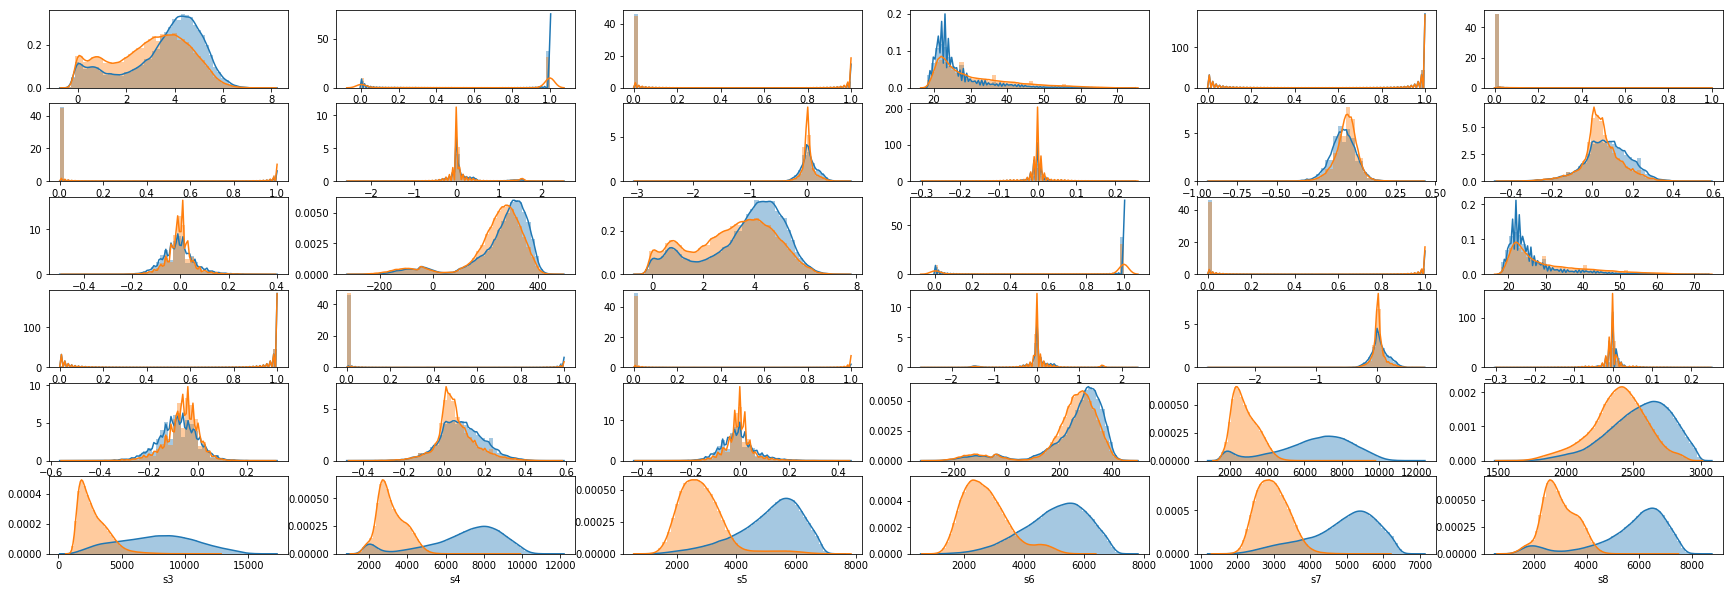

In [6]:
import seaborn as sns
from math import ceil

def plot_dataframe_variables(df,y):
    plt.figure(figsize=(30,10))
    col_number = df.shape[1]
    line_plot = math.ceil(np.sqrt(col_number))
    col_list = df.columns.values
    for i in range(col_number):
        #feature = 's'+str(i)
        plt.subplot(line_plot,line_plot,i+1) # because the first is 1 in the grid
        #sns.distplot(xtrain[[feature]].iloc[np.where(ytrain==1)],label = 'same picture')
        #sns.distplot(xtrain[[feature]].iloc[np.where(ytrain==0)], label = 'not same picture')
        #sns.distplot(df.iloc[np.where(y==0),i-1],label = '0')
        #sns.distplot(df.iloc[np.where(y==1),i],label = '1')
        sns.distplot(xtrain[[col_list[i]]].iloc[np.where(y==1)],label = '1')
        sns.distplot(xtrain[[col_list[i]]].iloc[np.where(y==0)], label = 'O')
        #plt.title(f'distribution of feature {feature}')
        plt.xlabel(list(df)[i])
        #plt.legend()
        
plot_dataframe_variables(xtrain,ytrain)

# Data cleaning & feature engineering

In [7]:
xtrain = pd.DataFrame(xtrain)
xtest = pd.DataFrame(xtest)
    

In [8]:

def create_my_features(df):
    for i in range(1,15):    
        df['sAB'+str(i)] = df['fA'+str(i)] + df['fB'+str(i)]
        df['s2AB'+str(i)] = df['fA'+str(i)] * df['fB'+str(i)]
        
        df['f2A'+str(i)] = df['fA'+str(i)]**2
        df['f2B'+str(i)] = df['fB'+str(i)]**2
        
        df['s3AB'+str(i)] = df['f2A'+str(i)] + df['f2B'+str(i)]
        df['s4AB'+str(i)] = df['f2A'+str(i)] * df['f2B'+str(i)]
        
        if i<9 :
            df['s5'+str(i)] = df['s'+str(i)]**2
        
    return df
        
xtrain = create_my_features(xtrain)
xtest = create_my_features(xtest)


In [9]:
# We normalise the data

sc = StandardScaler().fit(xtrain)
xtrain = sc.transform(xtrain)
xtest = sc.transform(xtest)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


Text(0,0.5,'Eigenvalue')

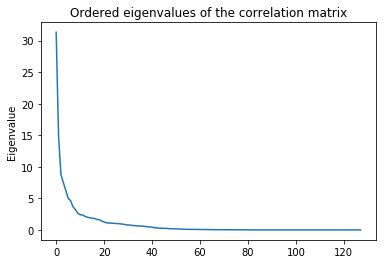

In [10]:
#Visualisation
#########################

# We compute the eigenvalues and eigenvectors
eigenValues, eigenVectors = np.linalg.eigh(pd.DataFrame(xtrain).cov())
#eigenValues

# We sort the values
idx = eigenValues.argsort()[::-1]
sort_eig = eigenValues[idx]    
sort_vect = eigenVectors[:, idx]

# We plot the eigenvalues ordered
plt.figure()
#sorted_eig = pd.Series(eigenValues).sort_values(ascending=False).reset_index()
sorted_eig = pd.Series(sort_eig)
graph2 = sorted_eig.plot()
graph2.set_title("Ordered eigenvalues of the correlation matrix" )
graph2.set_ylabel("Eigenvalue" )

####################

In [11]:
# PCA selection, not effective here
"""
pca = PCA(n_components=xtrain.shape[1])

# We train it on the train data
model_pca = pca.fit(xtrain)

# We transform the data acording to the model (keeping 60 significativ variables)
xtrain = pd.DataFrame(model_pca.transform(xtrain))
xtest = pd.DataFrame(model_pca.transform(xtest))
"""


'\npca = PCA(n_components=xtrain.shape[1])\n\n# We train it on the train data\nmodel_pca = pca.fit(xtrain)\n\n# We transform the data acording to the model (keeping 60 significativ variables)\nxtrain = pd.DataFrame(model_pca.transform(xtrain))\nxtest = pd.DataFrame(model_pca.transform(xtest))\n'

In [12]:
# Sampling to test out model
sample = 100000
xtrain = xtrain[:sample]
ytrain = ytrain[:sample]

xtrain[:sample].shape

(100000, 128)

In [13]:
xtrain_split, xtest_split, ytrain_split, ytest_split = model_selection.train_test_split(xtrain, ytrain,test_size=0.2, random_state=SEED)

# Model Building

In [14]:
# Train the classifier on a part of the data set
#clf = XGBClassifier(verbose=True, learning_rate=0.4, n_estimators=50, random_state = SEED, n_jobs=-1)
#clf = LGBMClassifier(verbose=1, learning_rate=0.4, n_estimators=1000, random_state = SEED, n_jobs=-1,min_child_weight=0.4,class_weight=None,importance_type='split',colsample_bytree=1.0,min_child_samples=20, min_split_gain=0.0,num_leaves=31,reg_alpha=0.0,reg_lambda=0.0,subsample=1.0,subsample_for_bin=2000000,subsample_freq=0)
clf = RandomForestClassifier(n_jobs = -1, n_estimators = 500, verbose=1, random_state=SEED)
clf.fit(xtrain_split, ytrain_split)

#100

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=1234, verbose=1,
            warm_start=False)

In [15]:
ypred = clf.predict(xtest_split)
(ypred == ytest_split).mean()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished


0.97875

In [16]:
print(metrics.classification_report(ytest_split,ypred))
print("Classifier Accuracy :", metrics.accuracy_score(ytest_split,ypred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     14357
           1       0.99      0.93      0.96      5643

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.98      0.96      0.97     20000
weighted avg       0.98      0.98      0.98     20000

Classifier Accuracy : 0.97875


# Model optimisation

In [17]:

print(__doc__)

def optimise_my_model(classifier, tuned_parameters, X_train, X_test, y_train, y_test):
    
    scores = ['f1']

    for score in scores:
        print("################################################################")
        #print("\nTuning hyper-parameters for \n ###### %s ###### \n" % score)
        print()

        clf = GridSearchCV(classifier, tuned_parameters, cv=5)
        clf.fit(X_train, y_train)
        
        print("#########")
        print("Best parameters set found on development set:\n")
        print(clf.best_params_)
        print("#########\n")
        print("Grid scores on development set:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))

        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.\n")
        y_true, y_pred = y_test, clf.predict(X_test)

Automatically created module for IPython interactive environment


In [18]:
#RF
clf = RandomForestClassifier(n_jobs = -1, n_estimators = 100, verbose=1, random_state=SEED)

tuned_parameters_rf = [{'random_state': [SEED], 'verbose': [1], 'n_jobs': [-1],  'n_estimators': [100,200], \
                       'criterion': ['gini'],\
                       'max_features': [20,30]}]

optimise_my_model(clf, tuned_parameters_rf, xtrain_split, xtest_split, ytrain_split, ytest_split)

################################################################



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_

#########
Best parameters set found on development set:

{'criterion': 'gini', 'max_features': 30, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
#########

Grid scores on development set:

0.979 (+/-0.001) for {'criterion': 'gini', 'max_features': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.979 (+/-0.001) for {'criterion': 'gini', 'max_features': 20, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.979 (+/-0.001) for {'criterion': 'gini', 'max_features': 30, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.979 (+/-0.001) for {'criterion': 'gini', 'max_features': 30, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
The model is trained on the full development set.
The scores are computed on the full evaluation set.



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


In [19]:
# XGB
clf = XGBClassifier(verbose=True, learning_rate=0.4, n_estimators=5, random_state = SEED, n_jobs=-1)

tuned_parameters_xg = [{'random_state': [SEED], 'verbose': [1], 'n_jobs': [-1],  'n_estimators': [100,200], \
                       'learning_rate': [0.1,0.3,0.4], 'max_depth': [5], 'booster': ['gbtree'], 'reg_alpha': [0.1]}]
optimise_my_model(clf, tuned_parameters_xg, xtrain_split, xtest_split, ytrain_split, ytest_split)


################################################################

#########
Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'reg_alpha': 0.1, 'verbose': 1}
#########

Grid scores on development set:

0.980 (+/-0.002) for {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'reg_alpha': 0.1, 'verbose': 1}
0.982 (+/-0.002) for {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'reg_alpha': 0.1, 'verbose': 1}
0.981 (+/-0.001) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'reg_alpha': 0.1, 'verbose': 1}
0.982 (+/-0.002) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'reg_alpha': 0.1, 'verbose': 1}
0.98

In [20]:

#LGBM
clf = LGBMClassifier(verbose=2, learning_rate=0.1, n_estimators=100, random_state = SEED, n_jobs=-1,)

tuned_parameters_xg = [{'random_state': [SEED], 'verbose': [1], 'n_jobs': [-1],  'n_estimators': [100,200], \
                       'learning_rate': [0.1,0.3,0.4]}]
optimise_my_model(clf, tuned_parameters_xg, xtrain_split, xtest_split, ytrain_split, ytest_split)

################################################################

#########
Best parameters set found on development set:

{'learning_rate': 0.1, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
#########

Grid scores on development set:

0.981 (+/-0.001) for {'learning_rate': 0.1, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.982 (+/-0.001) for {'learning_rate': 0.1, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.977 (+/-0.008) for {'learning_rate': 0.3, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.975 (+/-0.012) for {'learning_rate': 0.3, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.970 (+/-0.005) for {'learning_rate': 0.4, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.967 (+/-0.006) for {'learning_rate': 0.4, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
The model is trained on the full development set.

In [21]:
#Extratree
clf = ExtraTreesClassifier(n_jobs = -1, n_estimators = 100, verbose=1, random_state=SEED)

tuned_parameters_ex = [{'random_state': [SEED], 'verbose': [1], 'n_jobs': [-1],  'n_estimators': [100,200], \
                       'criterion': ['gini','entropy'],\
                       'max_features': [20,30]}]

optimise_my_model(clf, tuned_parameters_ex, xtrain_split, xtest_split, ytrain_split, ytest_split)

################################################################



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.9s finished
[Parallel(n_jobs=4)]: Using b

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Usin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | el

#########
Best parameters set found on development set:

{'criterion': 'gini', 'max_features': 30, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
#########

Grid scores on development set:

0.978 (+/-0.001) for {'criterion': 'gini', 'max_features': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.978 (+/-0.002) for {'criterion': 'gini', 'max_features': 20, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.979 (+/-0.001) for {'criterion': 'gini', 'max_features': 30, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.979 (+/-0.001) for {'criterion': 'gini', 'max_features': 30, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.978 (+/-0.001) for {'criterion': 'entropy', 'max_features': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1234, 'verbose': 1}
0.978 (+/-0.001) for {'criterion': 'entropy', 'max_features': 20, 'n_estimators': 200, 'n_jobs': -1, 'random_stat

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


In [22]:
"""from sklearn.svm import SVC

#SVC
clf = SVC(verbose=1, random_state=SEED)

tuned_parameters_ex = [{'random_state': [SEED], 'verbose': [1], 'decision_function_shape': ['ovo','ovr'], 'degree': [3,4,5],\
                        'kernel': ['linear','poly','rbf']}]

optimise_my_model(clf, tuned_parameters_ex, xtrain_split, xtest_split, ytrain_split, ytest_split)"""

"from sklearn.svm import SVC\n\n#SVC\nclf = SVC(verbose=1, random_state=SEED)\n\ntuned_parameters_ex = [{'random_state': [SEED], 'verbose': [1], 'decision_function_shape': ['ovo','ovr'], 'degree': [3,4,5],                        'kernel': ['linear','poly','rbf']}]\n\noptimise_my_model(clf, tuned_parameters_ex, xtrain_split, xtest_split, ytrain_split, ytest_split)"

# Model Stacking

In [23]:
xtrain = pd.read_csv('xtrain_challenge.csv', error_bad_lines=False)
ytrain = pd.read_csv('ytrain_challenge.csv', error_bad_lines=False)
ytrain = np.array(ytrain).reshape(xtrain.shape[0])
xtest = pd.read_csv('xtest_challenge.csv', error_bad_lines=False)


In [27]:
model_list = []
clf1 = RandomForestClassifier(n_jobs = -1, n_estimators = 200, verbose=1, random_state=SEED,criterion= 'gini', max_features= 20)
clf2 = XGBClassifier(verbose=1, learning_rate=0.4, n_estimators=200, random_state = SEED, n_jobs=-1, max_depth= 5)
clf3 = LGBMClassifier(verbose=1, learning_rate=0.1, n_estimators=200, random_state = SEED, n_jobs=-1, min_child_weight=0.4,class_weight=None,importance_type='split',colsample_bytree=1.0,min_child_samples=20, min_split_gain=0.0,num_leaves=1000,reg_alpha=0.0,reg_lambda=0.0,subsample=1.0,subsample_for_bin=2000000,subsample_freq=0)
clf4 = ExtraTreesClassifier(verbose=1, n_estimators=200, random_state = SEED, n_jobs=-1,max_features=30)
clf5 = LinearDiscriminantAnalysis()
model_list.append(clf1)
model_list.append(clf2)
model_list.append(clf3)
model_list.append(clf4)
model_list.append(clf5)

In [28]:
def model_list_predictions(model_list,xtrain,ytrain,xtest):
    for model in model_list:
        model.fit(xtrain,ytrain)
        prediction_train = model.predict(xtrain)
        prediction_test = model.predict(xtest)
        pd.concat([xtrain,pd.DataFrame(prediction_train)],axis=1)
        pd.concat([xtest,pd.DataFrame(prediction_test)],axis=1)
    

In [29]:
xtrain_split, xtest_split, ytrain_split, ytest_split = model_selection.train_test_split(xtrain, ytrain,test_size=0.2, random_state=SEED)

In [30]:
model_list_predictions(model_list,xtrain_split,ytrain_split,xtest_split)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 728.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 734.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 192 tas

In [31]:
new_clf = XGBClassifier(verbose=True, learning_rate=0.4, n_estimators=300, random_state = SEED, n_jobs=-1)


In [32]:
new_clf.fit(xtrain_split, ytrain_split)
ypred = new_clf.predict(xtest_split)
(ypred == ytest_split).mean()

0.9850991642329886

In [33]:
print(metrics.classification_report(ytest_split,ypred))
print("Classifier Accuracy :", metrics.accuracy_score(ytest_split,ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    456443
           1       0.99      0.96      0.97    182850

   micro avg       0.99      0.99      0.99    639293
   macro avg       0.99      0.98      0.98    639293
weighted avg       0.99      0.99      0.99    639293

Classifier Accuracy : 0.9850991642329886


*Here we did not fully optimized all the models, but the stacking improved the performance of each algorithm alone*

# Creating submission

In [34]:
# We retrain the model on the full set to have the best one for submission

xtrain = pd.read_csv('xtrain_challenge.csv', error_bad_lines=False)
ytrain = pd.read_csv('ytrain_challenge.csv', error_bad_lines=False)
ytrain = np.array(ytrain).reshape(xtrain.shape[0])
xtest = pd.read_csv('xtest_challenge.csv', error_bad_lines=False)



In [ ]:
clf = LGBMClassifier(verbose=4, learning_rate=0.05, n_estimators=5000, random_state = SEED, n_jobs=-1,min_child_weight=0.4,class_weight=None,importance_type='split',colsample_bytree=1.0,min_child_samples=20, min_split_gain=0.0,num_leaves=400,reg_alpha=0.0,reg_lambda=0.0,subsample=1.0,subsample_for_bin=2000000,subsample_freq=0)
#good = clf = LGBMClassifier(verbose=4, learning_rate=0.05, n_estimators=5000, random_state = SEED, n_jobs=-1,min_child_weight=0.4,class_weight=None,importance_type='split',colsample_bytree=1.0,min_child_samples=20, min_split_gain=0.0,num_leaves=500,reg_alpha=0.0,reg_lambda=0.0,subsample=1.0,subsample_for_bin=2000000,subsample_freq=0)

# Train the classifier on a part of the data set
clf.fit(xtrain, ytrain)

In [ ]:

# Classify the provided test data
ytest = clf.predict(xtest)
print(ytest.shape)


In [ ]:
time = strftime("%Y-%m-%d_%H-%M", gmtime())
np.savetxt('sub\\ytest_challenge_larrieu_valentin-'+time+'.csv', ytest, fmt = '%1.0d', delimiter=',')

In [0]:
#When we work on google colab, we need to get our data back
"""
from google.colab import files

files.download('ytest_challenge_larrieu_valentin-'+time+'.csv')
"""